In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML(""))
import scienceplots
plt.style.use(['science', 'no-latex'])
import folium
from folium import plugins
from folium.plugins import HeatMap

In [2]:
# import
la = pd.read_csv("prepared_data.csv", parse_dates=["start_time","end_time"],low_memory=False)

In [3]:
la.head(3)

,Unnamed: 0,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,Date,Weekday,Hour,Month
0,0,2019-01-01 00:07:00,2019-01-01 00:14:00,3046,3051,06468,Walk-up,2nd & Hill,7th & Broadway,7.0,2019-01-01,1,0,1
1,1,2019-01-01 00:08:00,2019-01-01 00:14:00,3046,3051,12311,Walk-up,2nd & Hill,7th & Broadway,6.0,2019-01-01,1,0,1
2,2,2019-01-01 00:18:00,2019-01-01 00:50:00,3030,3075,05992,Walk-up,Main & 1st,Broadway & 9th,32.0,2019-01-01,1,0,1


In [4]:
# counting which station is used how often
start_count = la['start_station_name'].value_counts()
end_count = la['end_station_name'].value_counts()

In [5]:
# new dataframe 
station_df = start_count.to_frame().rename(columns = {'start_station_name': 'start_count'})
station_df['end_count'] = end_count
station_df['sum'] = station_df['start_count'] + station_df['end_count']
station_df['station_name'] = station_df.index
station_df = station_df.sort_values(by='sum', ascending=False)
station_df.reset_index(drop=True, inplace=True) 
station_df.head(3)

,start_count,end_count,sum,station_name
0,13890,14630,28520,7th & Flower
1,13005,11377,24382,Main & 1st
2,10783,11996,22779,Union Station West Portal


Text(0.5, 1.0, '50 most used stations')

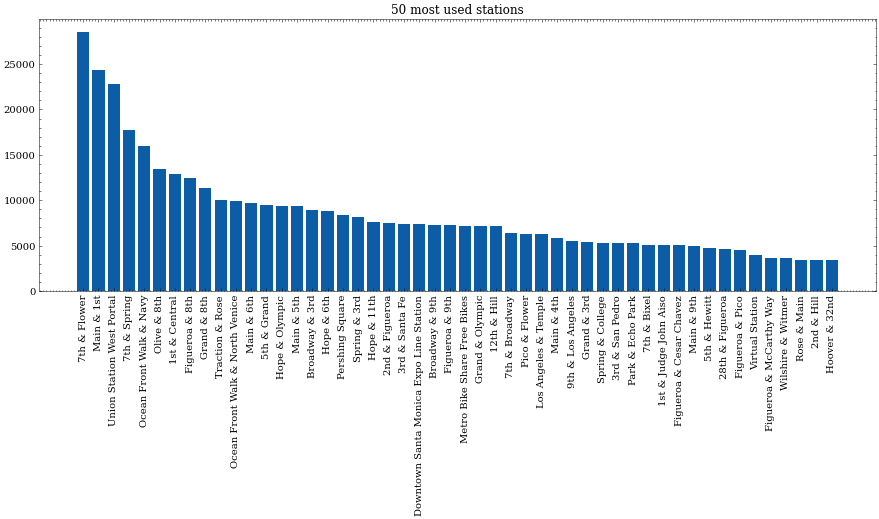

In [6]:
# plot of 50 most used stations
fig, ax = plt.subplots(figsize=[15,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=10)
ax.bar(station_df['station_name'].iloc[:50], station_df['sum'].iloc[:50])
plt.title('50 most used stations')

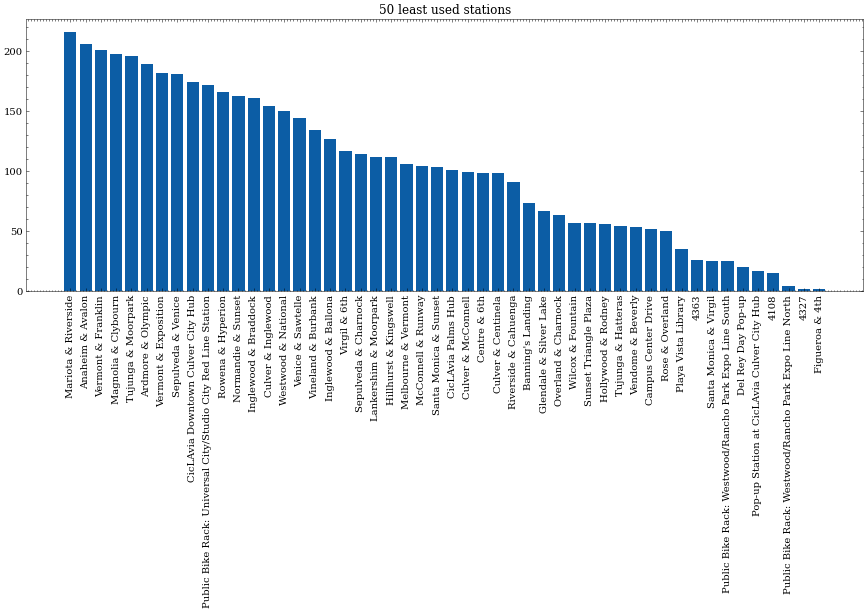

In [7]:
# plot of 50 least used stations
fig, ax = plt.subplots(figsize=[15,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=10)
ax.bar(station_df['station_name'].iloc[-50:], station_df['sum'].iloc[-50:])
plt.title('50 least used stations')
plt.show()

In [8]:
# new dataframe for most used routes
la["route"] = (la["start_station_name"] +" to "+ la["end_station_name"])
route = la['route'].value_counts()
route_df = route.to_frame().rename(columns={'route': 'count'})
route_df['route'] = route_df.index
route_df.head(3)

,count,route
Main & 1st to Union Station West Portal,5135,Main & 1st to Union Station West Portal
Union Station West Portal to Main & 1st,4395,Union Station West Portal to Main & 1st
Ocean Front Walk & Navy to Ocean Front Walk & Navy,4080,Ocean Front Walk & Navy to Ocean Front Walk & ...


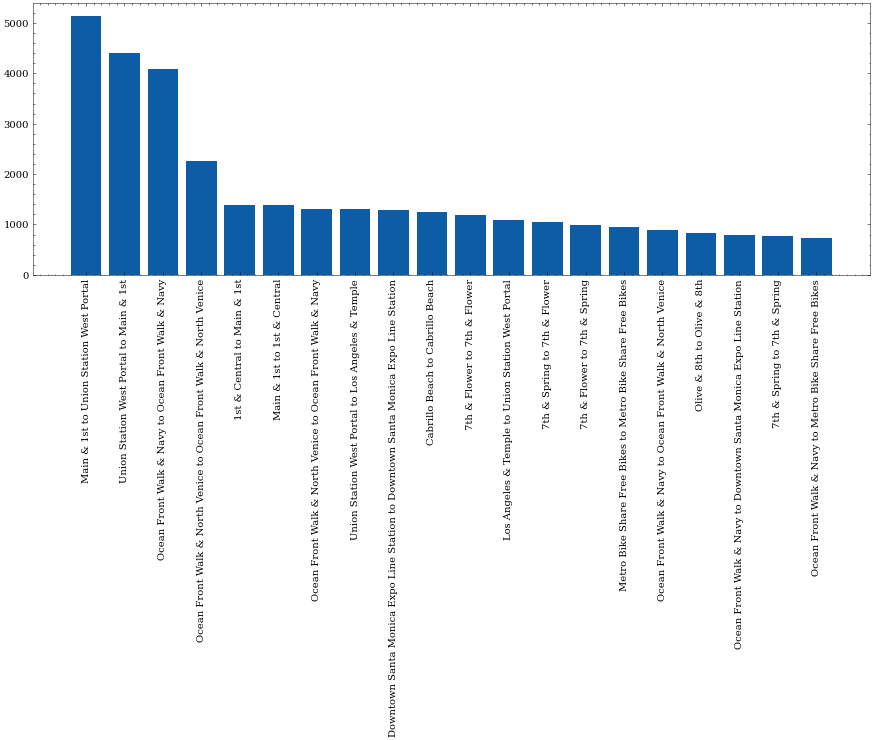

In [9]:
# plot of 20 most traveled routes
fig, ax = plt.subplots(figsize=[15,5])
plt.setp(ax.xaxis.get_majorticklabels(),rotation=90,fontsize=10)
ax.bar(route_df['route'].iloc[:20], route_df['count'].iloc[:20])
plt.show()

In [10]:
# new data set with station information (locations)
# https://gbfs.bcycle.com/bcycle_lametro/station_information.json
coordinates = pd.read_csv("station_information.csv")
# drop unnecessary columns
coordinates = coordinates.drop(columns=['ttl', 'data__stations__rental_uris__ios','data__stations__rental_uris__android','version','last_updated'])
coordinates.head(3)


,data__stations__lon,data__stations__lat,data__stations___bcycle_station_type,data__stations__region_id,data__stations__address,data__stations__name,data__stations__station_id
0,-118.25854,34.04850,Kiosk and Station,bcycle_lametro_region_1,Reinstalled 6/15,7th & Flower,bcycle_lametro_3005
1,-118.25667,34.04554,Kiosk and Station,bcycle_lametro_region_1,729 S Olive Street,Olive & 8th,bcycle_lametro_3006
2,-118.25459,34.05048,Kiosk and Station,bcycle_lametro_region_1,557 S 5th Street,5th & Grand,bcycle_lametro_3007


In [11]:
# adding coordinates to stations
coordinates["ziped_coords"] = list(zip(coordinates["data__stations__lat"],coordinates["data__stations__lon"]))
station_df = station_df.merge(coordinates["ziped_coords"].to_frame(),how = "left",left_on=station_df["station_name"],right_on=coordinates["data__stations__name"])
station_df = station_df.drop(columns=["key_0"])

# dropping stations without location data
station_df = station_df.dropna(axis=0)
station_df.head(3)

,start_count,end_count,sum,station_name,ziped_coords
0,13890,14630,28520,7th & Flower,"(34.0485, -118.25854)"
1,13005,11377,24382,Main & 1st,"(34.05194, -118.24353)"
2,10783,11996,22779,Union Station West Portal,"(34.05661, -118.23721)"


In [12]:
# stations; size --> logarithmic number of started tours
log_map = folium.Map(location=(34.052235, -118.243683),tiles='OpenStreetMap',zoom_start=11, control_scale=True, max_zoom=20)

# drawing maps and dots
#for index, row in station_df.iterrows():
 #   folium.CircleMarker(radius=np.power(np.log(row["activities"])/4,1.5, location=row["ziped_coords"], popup=row["station_name"], color="red", fill_color="red",weight=2).add_to(log_map)

log_map
# adding the most used stations in green
for index, row in station_df.iloc[:50].iterrows():
    folium.CircleMarker(radius=5, location=row["ziped_coords"], popup=row["station_name"], color="green", fill_color="green",weight=2).add_to(log_map)
    
#add the least used stations in red
for index, row in station_df.iloc[-50:].iterrows():
    folium.CircleMarker(radius=5, location=row["ziped_coords"], popup=row["station_name"], color="red", fill_color="red",weight=2).add_to(log_map)
    
log_map

In [13]:
#points = []
#points.append(tuple([34.0485, -118.25854]))
#points.append(tuple([34.05194, -118.24353]))
#folium.PolyLine(points,color='blue',weight=3).add_to(log_map)
#log_map

In [14]:
#la = la.merge(coordinates["ziped_coords"].to_frame(),how = "left",left_on=la["start_station_name"],right_on=coordinates["data__stations__name"])
#la = la.rename(columns={'ziped_coords': 'start_coords'})
#la = la.drop(columns=["key_0"])
#la = la.merge(coordinates["ziped_coords"].to_frame(),how = "left",left_on=la["end_station_name"],right_on=coordinates["data__stations__name"])
#la = la.rename(columns={'ziped_coords': 'end_coords'})
#la = la.drop(columns=["key_0"])
#la = la.dropna(axis=0)
#la.head(3)

In [15]:
#route_df
#la = la.merge(route_df)
#la = la.sort_values(by='count', ascending=False)

In [16]:
#la_copy = la.copy()
#la_copy = la_copy.drop_duplicates(subset=['route'])
#la_copy.head(3)

In [17]:
#la_copy["start_coords"].iloc[10]

In [18]:
#points = []
#for i in range(20):
  #      points.append(tuple(la_copy["start_coords"].iloc[i]))
 #       points.append(tuple(la_copy["end_coords"].iloc[i]))
#points.append(tuple([34.0485, -118.25854]))
#points.append(tuple([34.05194, -118.24353]))
#folium.PolyLine(points,color='blue',weight=3).add_to(log_map)

#log_map

In [19]:
user_type = la['user_type'].value_counts()

In [20]:
user = user_type.to_frame()
user

,user_type
Monthly Pass,169677
Walk-up,77857
Annual Pass,21078
One Day Pass,14128
Flex Pass,313
Testing,82


In [21]:
# stations; size --> logarithmic number of started tours
log_map_2 = folium.Map(location=(34.052235, -118.243683),tiles='OpenStreetMap',zoom_start=11, control_scale=True, max_zoom=20)

# drawing maps and dots
for index, row in station_df.iterrows():
    folium.CircleMarker(radius=np.power(np.log(row["sum"])/4,1.5), location=row["ziped_coords"], popup=row["station_name"], color="red", fill_color="red",weight=2).add_to(log_map_2)

log_map_2